[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


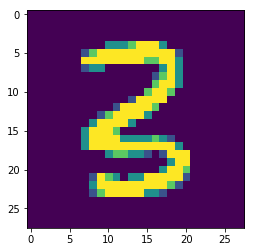

In [3]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from matplotlib import pyplot as plt
import collections
import random
pixel_depth = 255

def prep_data(csv):
    data = pd.read_csv(csv)
    labels = None
    #One-hot encoding for labels
    if csv == 'train.csv':
        labels = (np.arange(10) == (data['label'])[:,None]).astype(np.float32)
    #Turn 28x28 images into 1-d array of length 784
    image = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
    data = np.array(data[image])
    data = data.astype('float32').reshape(-1,784)
    #Rescale pixel values from a range of 0-255 to 0-1
    data = (data - np.min(data))/np.ptp(data)
    return data, labels

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_data, train_labels = prep_data('train.csv')
train_data, train_labels = randomize(train_data, train_labels)

#Display a random image from the dataset
x = random.randint(1,len(train_labels))
print(train_labels[x])
plt.imshow(train_data[x].reshape(28,28))
plt.show()

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Initialized variables.
Training step: 0 Accuracy: 0.23828125 Loss: 2.1722198
Training step: 500 Accuracy: 0.75390625 Loss: 0.6967148
Training step: 1000 Accuracy: 0.7832031 Loss: 0.6323843
Training step: 1500 Accuracy: 0.75390625 Loss: 0.56493515
Training step: 2000 Accuracy: 0.82421875 Loss: 0.51299274
Training step: 2500 Accuracy: 0.80859375 Loss: 0.55335104
Training step: 3000 Accuracy: 0.8125 Loss: 0.57923335
Training step: 3500 Accuracy: 0.8027344 Loss: 0.562034
Training step: 4000 Accuracy: 0.8359375 Loss: 0.5174805
Training step: 4500 Accuracy: 0.8261719 Loss: 0.50985754
Training step: 5000 Accuracy: 0.8203125 Loss: 0.47626492
Training step: 5500 Accuracy: 0.83203125 Loss: 0.51415664
Training step: 6000 Accuracy: 0.81640625 Loss: 0.5732682
Training step: 6500 Accuracy: 0.8203125 Loss: 0.4

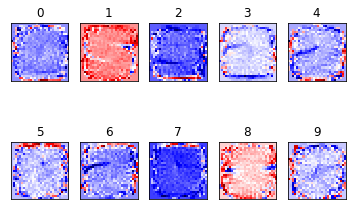

In [8]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

#import test data 
test_data = mnist.test.images
test_labels = mnist.test.labels

DIR = './graph'
image_size = 28
num_classes = 10
batch_size = 512 #Need to determine which batch_size is getting best results
learning_rate = 0.003 #Need to try implementing lr decay 
num_steps = 10000

def nn_model(data, weights, biases):
    layer_1 = tf.matmul(data, weights['lay1']) + biases['lay1']
    relu = tf.nn.relu(layer_1)
    relu_d = tf.nn.dropout(relu, pkeep)
    layer_2 = tf.matmul(relu_d, weights['lay2']) + biases['lay2']
    return layer_2

def accuracy(predicitions, labels):
    return 100 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

graph = tf.Graph()

with graph.as_default():
    
    with tf.name_scope('Input'):
        tf_train_data = tf.placeholder(tf.float32, shape=(None, image_size * image_size), name='images')
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
        tf_test_data = tf.constant(test_data, name='test_images')
        pkeep = tf.placeholder(tf.float32, name="pkeep")
    
    with tf.name_scope('Layers'):
        weights = {
            'lay1': tf.Variable(tf.zeros([image_size * image_size, num_classes]), name='weights1'),
            'lay2': tf.Variable(tf.truncated_normal([num_classes, num_classes]), name='weights2')
        }

        biases = {
            #Important to not define initial biases being passed to relu as zeros to prevent the "dying relu" problem 
            'lay1': tf.Variable((tf.ones([num_classes])/10), name='biases1'), 
            'lay2': tf.Variable(tf.zeros([num_classes]), name='biases2')
        }

        logits = nn_model(tf_train_data, weights, biases)
        
    with tf.name_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels)) 
        tf.summary.scalar('loss', loss)
    
    with tf.name_scope('Optimizer'):
        #AdamOptimizer yields better results but GDOptimizer yields better visualization of weights, why?
        #Also need to learn more about how these optimizers work 
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) 
    
    with tf.name_scope('Evaluation'):
        train_prediction = tf.nn.softmax(logits)
        correct_prediction = tf.equal(tf.argmax(train_prediction,1), tf.argmax(tf_train_labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

with tf.Session(graph=graph) as sess:
    #For tensorboard
    train_writer = tf.summary.FileWriter(os.path.join(DIR, 'train'), sess.graph)
    test_writer = tf.summary.FileWriter(os.path.join(DIR, 'test'), sess.graph)
    summary_op = tf.summary.merge_all()
    
    #Training model
    sess.run(tf.global_variables_initializer())
    print('Initialized variables.')
    with tf.name_scope('training'):
        for step in range(num_steps + 1):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_data[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            summary_result, _ = sess.run([summary_op, optimizer], feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, pkeep: 0.75})
            train_writer.add_summary(summary_result, step)
            
            if step % 500 == 0:
                print('Training step: ' + str(step) + ' Accuracy: ' + str(sess.run(accuracy, feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, pkeep: 0.75})) + ' Loss: ' + str(sess.run(loss, feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, pkeep: 0.75})))
        
        #Need to figure out how to correctly display test data results in an informative way on tensorboard
        print('Test accuracy: ' + str(sess.run(accuracy, feed_dict={tf_train_data: test_data, tf_train_labels: test_labels, pkeep: 1.0}))) 
        summary_result, acc = sess.run([summary_op, accuracy], feed_dict={tf_train_data: test_data, tf_train_labels: test_labels, pkeep: 1.0})
        #test_writer.add_summary(summary_result, acc)

    #Visualize weights
    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(weights['lay1'])[:,i]
        plt.title(i)
        plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()
        
train_writer.close()
test_writer.close()